# **Public finance - modelling intensive margin labor supply**


First we import the relevant packages that we use. Furter on we also import different function that we use.

In [1]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import time
from scipy import linalg
from scipy import optimize
import sympy as sm
import seaborn as sns
from IPython import display

#import our own functions
from modelproject import (budget_cons, budget_cons_comp, comp_cons,sol_func_top_tax,budget_cons_top_tax, labor_supply_fig_func)

#set format for output
sm.init_printing(use_unicode=True)

# Hvad gør disse?
%load_ext autoreload
%autoreload 2

In [2]:
np.seterr(all='print')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Describe the model

In this notebook we want to examine the intensive labor supply i.e. hours worked given employment. We derive the optimal level of labor supply for a given household and see how it depends on the models parameter. Lastly we extend the model by introducing a progressive tax system. 

**The setup:**

The householdse maxmize utility which is a function of consumption and leisure. The time endowment is normalized to 1, hence leisure can be expressed as $1-h$ where $h$ is the relative time worked. The householde maxmize their utility subjected to the budget constraint. 

\\[ \max u(x,1-h) \text{ s.t. } p\cdot x=(1-t_{w})wh-t_{0}+a \\]

 - $u(\cdot)$ is the utility funciton
 - $x$ is consumption
 - $p$ is the price of consumption
 - $1-h$ is leisure
 - $w$ is the wage
 - $t_{w}$ is a tax on labor income
 - $t_{0}$ is lump sum tax
 - $a$ is non-labor income
 
 We set the price as numeraire, $p=1$. 

Is the notebook we will define utility function as a quasi-linear utility function:

\\[ u(x,1-h)=x+\frac{1}{1+\frac{1}{\varepsilon}}(1-h)^{1+\frac{1}{\varepsilon}} \\]

where $\varepsilon$ is the elasticity of substitution which is given by:

\\[ \varepsilon= \frac{dh}{d(1-t_w)w}\cdot \frac{(1-t_w)w}{h} \\]

# Define the model in Python

Specify the symbols

In [3]:
x = sm.symbols('x')             # consumption
h = sm.symbols('h')             # working share
epsilon = sm.symbols('epsilon') # elasticity
tw = sm.symbols('t_w')          # tax on labor income
w = sm.symbols('w')             # wage
t0 = sm.symbols('t_0')          # lump sump tax
a = sm.symbols('a')             # non-labor income

Defining the utility function:

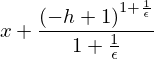

In [4]:
utility=x+(1/(1+1/epsilon))*(1-h)**(1+1/epsilon)
utility

Defining the budget constraint

In [5]:
budget_con = sm.Eq(x,(1-tw)*w*h-t0+a)
budget_con

# Solve the model

There are several ways to solve the model. In this note notebook we will solve the model by substituion, which implies that the algoritm for finding the optimal level on labor supply is:

1. Insert the budget constraint in the utility function
2. Take the derivative wrt. $h$
3. Solve the first order condition for $h$

**Step 1**

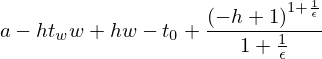

In [6]:
# Find the expression for consumption in the budget constraint
x_from_con=sm.solve(budget_con,x)
# Insert the budget constraint in the utility function
utility_sub=utility.subs(x,x_from_con[0])
utility_sub

**Step 2**

In [7]:
#Find first derivative wrt. h and simplify the expression
foc=sm.diff(utility_sub,h)
foc_sim=sm.simplify(foc)
foc_sim

**Step 3**

In [8]:
#Find the optimal h as a function of the model parameters
sol = sm.solve(foc_sim,h)
sol

From the expression above we can see that the optimal level of $h$ only dependt on the wage, the marginal tax on labor income and the elasticity. 

# Use solutions

We define the parameters in model to be: $\varepsilon=-0.9$, $a=2$, $w=10$, $t_w=0.2$ and $t_0=1$. Be aware that these are the standard values in all the functions so if you only change the value in one function other functions might return wrong values as they are based on another set of standard values. 
 
In the following we will use the solution to see what happens when the tax increases from 20 pct. to 50. pct.

In [9]:
# Turn the optimal level of h into a Python function.
_sol_func=sm.lambdify((tw,w,epsilon),sol[0])
def sol_func(tw=0.2,w=10,epsilon=-0.9,a=2,t0=1):
    #First we calculate the optimal level of h
    opt_h=_sol_func(tw,w,epsilon)
    #Then we calculate the level of consumption by inserting the optimal h into the budget constraint
    opt_x=(1-tw)*w*opt_h-t0+a
    #Lastly we calculate the implied utility
    opt_u=opt_x+1/(1+1/(epsilon))*(1-opt_h)**(1+1/(epsilon))
    return opt_h, opt_x, opt_u

# find optimum for hours worked, concsumption level and the implied utility 
        #We use the standard parameters specified in the function
optimal_h,optimal_x,optimal_u=sol_func()
print('Optimal level of h, before tax change','%.2f' % optimal_h)
print('Optimal level of x, before tax change','%.2f' % optimal_x)
print('Implied utility, before tax change','%.2f' % optimal_u)

# find optimum for hours worked, consumption level and the implied utility when the tax increases from 20 pct. to 50 pct. 
optimal_h_tax,optimal_x_tax,optimal_u_tax=sol_func(tw=0.5)
print('Optimal level of h, before tax change','%.2f' % optimal_h_tax)
print('Optimal level of x, before tax change','%.2f' % optimal_x_tax)
print('Implied utility, before tax change','%.2f' % optimal_u_tax)

#Find the changes in h and x:
print('Total change, h:',"%.2f" % (optimal_h-optimal_h_tax))
print('Total change, x:',"%.2f" % (optimal_x-optimal_x_tax))

Optimal level of h, before tax change 0.85
Optimal level of x, before tax change 7.77
Implied utility, before tax change -3.31
Optimal level of h, before tax change 0.77
Optimal level of x, before tax change 4.83
Implied utility, before tax change -5.75
Total change, h: 0.08
Total change, x: 2.94


We can therefore see that when the tax increase from 20 pct. to 50 pct. the labor supply decrease with 0.8 and the consumption decrease with 2.9. 

The change in labor supply and consumption can be split up into two effects: Substitution and income effect. 
To illustrate the substitution and income effect of a tax increase we find the compensated optimum.

As the utility function is quasi-linear there are no income effect, which implies that the optimal level of  $h$ is the same under the with and wihtout compensation. 

The compensated level of compensation can be found rearraging the utility slightly:

\\[x=\bar{u}-\frac{1}{1+\frac{1}{\varepsilon}}(1-h)^{1+\frac{1}{\varepsilon}} \\]

Where $\bar{u}$ is the compensated utility. This function is defined in model package as comp_cons

In [11]:
#Compensated level of h:
optimal_h_com=optimal_h_tax

#Compensated level of c:
optimal_x_com=comp_cons(h=optimal_h_com,u=optimal_u)

We can therefore find the different substitution and income effect as

In [12]:
print('Sub. effect, h:',"%.2f" % (optimal_h-optimal_h_com))
print('Sub. effect, x:',"%.2f" % (optimal_x-optimal_x_com))
print('Inc. effect, h:',"%.2f" % (optimal_h_com-optimal_h_tax))
print('Inc. effect, x:',"%.2f" % (optimal_x_com-optimal_x_tax))


Sub. effect, h: 0.08
Sub. effect, x: 0.51
Inc. effect, h: 0.00
Inc. effect, x: 2.43


Next we want to illustrate the effect of a tax changes which is done in the following code. Some of the functions that we use to draw the plot are defined in the package "model" with the standard parameter. 

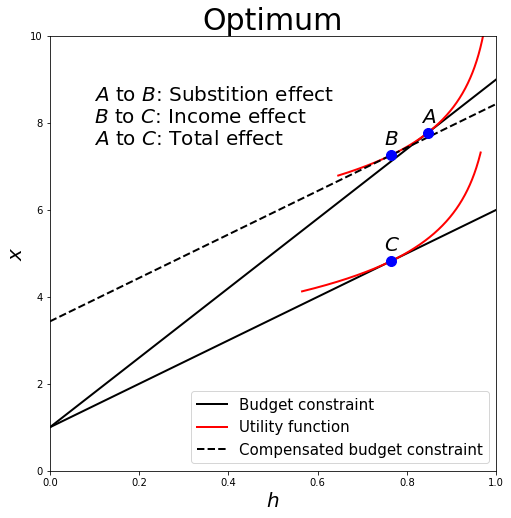

In [13]:
#make different grids to evaluate the two functions with
#grid for the budget constraint
grid = np.linspace(0,1,500)
#grid for the utility function before tax
grid_b = np.linspace(optimal_h-0.2,optimal_h+0.2,500)
#grid for the utility function after the tax increase
grid_b_tax = np.linspace(optimal_h_tax-0.2,optimal_h_tax+0.2,500)

#before tax increase
#evaluate the budget constraint for different values of h
budget_line=budget_cons(grid)

# The line for the utility fucntion can be found by evaluating the compensated consumption for 
# different values of h for a given level of utility which in this case is the optimal level of utility before the tax increase
u_func_opt=comp_cons(grid_b,optimal_u)

#after tax increase
#the budget line after the tax increase
budget_line_tax=budget_cons(grid,tw=0.5)
#The compensated budget line
budget_line_tax_com=budget_cons_comp(grid,optimal_u,optimal_u_tax)
#The utility function in the new optimum
u_func_opt_tax=comp_cons(grid_b_tax,optimal_u_tax)


#Create the plot
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(1,1,1)

#budget line before tax change
ax.plot(grid,budget_line,lw=2,linestyle='-',color='black',label='Budget constraint',zorder=-1)
#Utility function before tax change
ax.plot(grid_b,u_func_opt,lw=2,linestyle='-',color='red',label='Utility function',zorder=-1)
#budget line after tax increase
ax.plot(grid,budget_line_tax,lw=2,linestyle='-',color='black',zorder=-1)
#Compensated budget line
ax.plot(grid,budget_line_tax_com,lw=2,linestyle='--',color='black',label='Compensated budget constraint',zorder=-1)
#utility function after the tax increase
ax.plot(grid_b_tax,u_func_opt_tax,lw=2,linestyle='-',color='red',zorder=-1)

#Add a dot in the optimum before the tax increase called A
plt.scatter(optimal_h, optimal_x, s=100, zorder=1,marker="o",color='blue')
plt.annotate('$A$',xy=(optimal_h, optimal_x),xytext=(-7,10),textcoords='offset points',fontsize=20)

#Add a dot in the compensated optimum called B
plt.scatter(optimal_h_com, optimal_x_com, s=100,zorder=1, marker="o",color='blue')
plt.annotate('$B$',xy=(optimal_h_com, optimal_x_com),xytext=(-7,10),textcoords='offset points',fontsize=20,)

#Add a dot in the new optimum called C
plt.scatter(optimal_h_tax, optimal_x_tax, s=100, zorder=1,marker="o",color='blue')
plt.annotate('$C$',xy=(optimal_h_tax, optimal_x_tax),xytext=(-7,10),textcoords='offset points',fontsize=20,)

# Add a note in the figure
plt.text(0.1, 7.5,'$A$ to $B$: Substition effect \n$B$ to $C$: Income effect \n$A$ to $C$: Total effect', fontsize=20)

# Set the limits of the y-axis
ax.set_ylim([0,10]);
ax.set_xlim(0,1)
#set  legends
ax.legend(loc='lower right',fontsize=15)
#add labels and title
ax.set_xlabel('$h$',fontsize=20)
ax.set_ylabel('$x$',fontsize=20)
ax.set_title('Optimum',fontsize=30)
#plot the figure
plt.show()

# Optimize the utility numerically

Antoher way to solve the model is to use numerical optimization. To simplify the notation, we use the utility-function expressed only as a function $h$. We therefore insert the budget constraint in the utility function and use the standard values of the parameters from the previous models. 

In [14]:
#define the utility function
def utility_func(h):
    return -((1-0.2)*10*h-1+2+(1/(1+1/(-0.9)))*(1-h)**(1+1/(-0.9)))
#define the first derivative:
def utility_dif(h):
    return (-1)*(-0.2*10+10-(1-h)**(1/(-0.9)))


Before we optimize the utility we make a plot to see the problem of interest. 

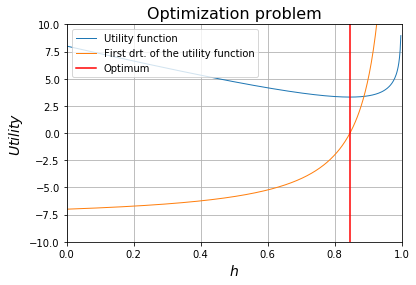

In [17]:
# evaluate the utility function 
u_grid=utility_func(grid)
u_dif=utility_dif(grid)

#create the figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

#plot the utility function
ax.plot(grid,u_grid,lw=1,label='Utility function')

#plot the first derivative
ax.plot(grid,u_dif,lw=1,label='First drt. of the utility function')

#Indicate the analytical optimum
ax.axvline(x=optimal_h, color='r',label='Optimum')

#set different layout settings for the plot
ax.set_ylim([-10,10]);
ax.set_xlim(0,1);
ax.legend(loc='upper left')
ax.grid()
ax.set_xlabel('$h$', fontsize='14');
ax.set_ylabel('$Utility$', fontsize='14');
ax.set_title('Optimization problem', fontsize='16');
plt.show()

From the plot above we see that optimum for the function coresponds to the optimum we found analytically. That is that the first derivative is eqaul to 0 in the optimum.

As the our function just depend on $h$ we can find the numerical optimum with the following code:

In [19]:
h_scalar=optimize.minimize_scalar(utility_func,bounds=(0,1),method='bounded')
h_scalar.x

We see that the numerical optimization almost are identical to the analytical result. 

# Introduction of af top tax

In the previous example we assumed a linear tax system which implies that marginal tax rate is the same across income levels. In the following we will see what happens when we introduce a top tax. 

With a top tax the marginal tax rate increases from $t_{1}$ to $t_{2}>t_{1}$ when the pre tax income exceed a certain threshold $K$.

The budget constraint with progressives taxes can be written as:

\\[ x=(1-t_{1})\cdot min(wh,K)+(1-t_{2})\cdot max(h\cdot w-K,0)-t_{0}+a \\]

To find the optimal choice of $h$ we can use the solution from the previous model in a three step algorithm.

The algorithm to find the consumpers choice of $h$ is:
1. Calculate the optimal choice of $h$ under $t_{1}$ and check if this is a possible solution, i.e the income must be lower than $K$
2. Calculate the optimal choice of $h$ under $t_{2}$ and check if this is a possible solution, i.e the income must be lower than $K$
3. If neither of the two previous choices of $h$ are possible, the consumer will choose $h=\frac{K}{w}$ 

In [20]:
#Find optimum with a top tax
optimal_h_top,optimal_x_top,optimal_u_top=sol_func_top_tax(sol_func)

In [23]:
#Budget line with top tax
budget_line_top=[]
for i in grid:
    budget_line_top.append(budget_cons_top_tax(i))

#Grid around optimum with top tax
grid_b_top = np.linspace(optimal_h_top-0.2,optimal_h_top+0.2,500)

#Utility function with top tax
u_func_top=comp_cons(grid_b_top,optimal_u_top)

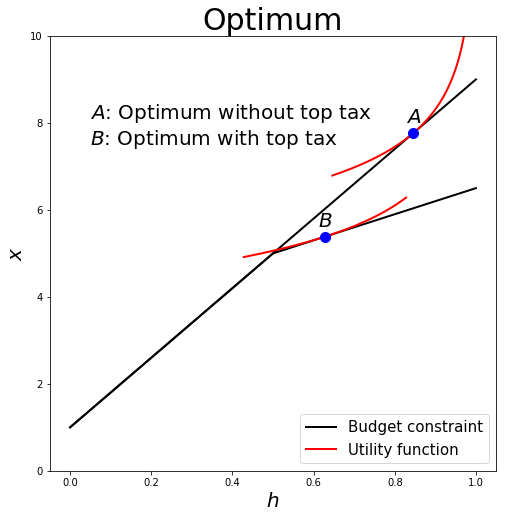

In [58]:
#create figure
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

#Plot the optimum before tax, where we just use the results from the previous section
ax.plot(grid,budget_line,lw=2,linestyle='-',color='black',label='Budget constraint',zorder=-1)
ax.plot(grid_b,u_func_opt,lw=2,linestyle='-',color='red',label='Utility function',zorder=-1)

#Plot the new optimum
ax.plot(grid,budget_line_top,lw=2,linestyle='-',color='black',zorder=-1)
ax.plot(grid_b_top,u_func_top,lw=2,linestyle='-',color='red',zorder=-1)

# Add a dot in optimum before top tax
plt.scatter(optimal_h, optimal_x, s=100, zorder=1,marker="o",color='blue')
plt.annotate('$A$',xy=(optimal_h, optimal_x),xytext=(-7,10),textcoords='offset points',fontsize=20)

# Add a dot i optimum with top tax
plt.scatter(optimal_h_top, optimal_x_top, s=100, zorder=1,marker="o",color='blue')
plt.annotate('$B$',xy=(optimal_h_top, optimal_x_top),xytext=(-7,10),textcoords='offset points',fontsize=20,)

#Add notes
plt.text(0.05, 7.5,'$A$: Optimum without top tax \n$B$: Optimum with top tax', fontsize=20)

#Set layout settings
ax.set_ylim([0,10]);
ax.legend(loc='lower right',fontsize=15)

ax.set_xlabel('$h$',fontsize=20)
ax.set_ylabel('$x$',fontsize=20)
ax.set_title('Optimum',fontsize=30)
plt.show()

# What happens when we change the elasticity of substitution

First we will show the labor supply curve for different values of $\varepsilon$. Lastly we will look at how the distribution of hours worked across different values of $\varepsilon$. 

### Plot labor supply curve for different values of epsilon 

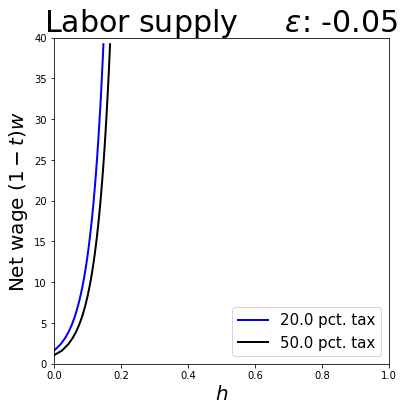

None

In [59]:
#Please run this twice (at least) to get the full experience!
color = ['red', 'black']

epsilon_array = np.arange(-1,0,0.05)
epsilon_list = [round(epsilon,2) for epsilon in epsilon_array]
epsilon_list.remove(-1)
for epsilon in epsilon_list:
    time.sleep(0.2)
    display.display(labor_supply_fig_func(epsilon, 0.2, 0.5, sol_func));
    display.clear_output(wait=True);

From the figure above we see as $\varepsilon$ becomes smaller, hence more inelastic, the labor supply curve become steeper. 

### The distribution of $h$ over different values of $\epsilon$

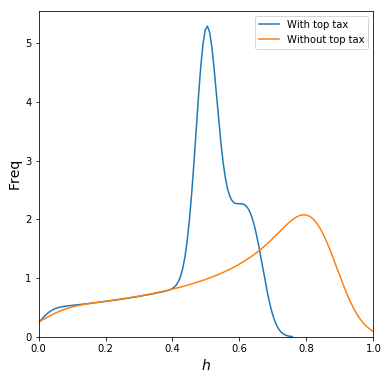

In [50]:
#Make a list over different values of epsilon
epsilon_array = np.arange(-1,0,0.001)
epsilon_list = [round(epsilon,3) for epsilon in epsilon_array]
#remove -1 from the list as it is not a posssile value
epsilon_list.remove(-1)
#Create empty list
hours=[]
hours_top=[]
#Loop through the list and calculate h for each value of epsilon
for i in epsilon_list:
    _hours,_cons,_utility=sol_func(epsilon=i)
    _hours_top,_cons,_utility=sol_func_top_tax(sol_func,epsilon=i)
    hours.append(_hours)
    hours_top.append(_hours_top)
    
#create the figure
fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(1,1,1)

#plot the distribution for the two different models
sns.distplot(hours_top, hist=False, label='With top tax');
sns.distplot(hours, hist=False,label='Without top tax');

#settings for the layout
ax.set_xlim(0,1)
plt.legend()
plt.ylabel('Freq', fontsize=14)
plt.xlabel('$h$', fontsize=14)
plt.show()

From the distribution above we can see that people bunch around the threshold for the top tax. 